In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from utils import tile_raster_images
from tensorflow.examples.tutorials.mnist import input_data


In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
x_train, y_train, x_test, y_test = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

In [3]:
x_train[1].shape

(784,)

MNIST images have 784 pixels(28 x 28), so the visible layer must have 784 input nodes. And lets have 50 nodes in our hidden layer

In [4]:
v_bias = tf.placeholder("float", [784])
h_bias = tf.placeholder("float", [50])

So, our Weight matrix will have a dimension of 784 x 50

In [5]:
W = tf.placeholder("float", [784, 50])

Visible layer:

In [6]:
v0_state = tf.placeholder("float", [None, 784])

Hidden layer:

In [7]:
h0_prob = tf.nn.sigmoid(tf.matmul(v0_state, W) + h_bias)  #probabilities of the hidden units
h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random_uniform(tf.shape(h0_prob)))) #sample_h_given_X

Reconstruction part:

In [8]:
v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + v_bias) 
v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random_uniform(tf.shape(v1_prob)))) #sample_v_given_h

Calculate Error: 

In [9]:
error = tf.reduce_mean(tf.square(v0_state - v1_state))

Here we want to give a high probability to the input data we train on. So, to train an RBM, we have to maximize the product of probabilities assigned to all rows v (images) in the training set V (a matrix where each row of it is treated as a visible vector v). <br>
<img src= "https://wikimedia.org/api/rest_v1/media/math/render/svg/d42e9f5aad5e1a62b11b119c9315236383c1864a" >
<br>
Which is equivalent to maximizing the expected log probability of V:<br>
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/ba0ceed99dca5ff1d21e5ace23f5f2223f19efc0"> <br>

    
And this cannot be easily done by typical stocastic gradient descent, so we will use another approach: <br>
1: Gibbs Sampling <br>
2: Contrasive Divergence

In the gibs sampling we traverse forward and pass the input through vairous layers 

And in the Contrasive Divergence step we update teh weight matrix by: <br>
$\Delta W = v0 \otimes h0 - vk \otimes hk$
<br>
$W' = W +  	α * \Delta W$

where α is the learning rate


Now lets assume that k = 1, that is we just get one more step

In [10]:
h1_prob = tf.nn.sigmoid(tf.matmul(v1_state, W) + h_bias)
h1_state = tf.nn.relu(tf.sign(h1_prob - tf.random_uniform(tf.shape(h1_prob))))

In [11]:
alpha = 0.01
W_Delta = tf.matmul(tf.transpose(v0_state), h0_prob) - tf.matmul(tf.transpose(v1_state), h1_prob)
update_w = W + alpha * W_Delta
update_v_bias = v_bias + alpha * tf.reduce_mean(v0_state - v1_state, 0)
update_h_bias = h_bias + alpha * tf.reduce_mean(h0_state - h1_state, 0)

Initializing the variables and starting the session

In [12]:
cur_w = np.zeros([784, 50], np.float32)
cur_v_bias = np.zeros([784], np.float32)
cur_h_bias = np.zeros([50], np.float32)
prev_w = np.zeros([784, 50], np.float32)
prev_v_bias = np.zeros([784], np.float32)
prev_h_bias = np.zeros([50], np.float32)
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

In [13]:
sess.run(error, feed_dict={v0_state: x_train, W: prev_w, v_bias: prev_v_bias, h_bias: prev_h_bias})

0.4815161

Epoch: 0 Reconstruction error: 0.091828
Epoch: 1 Reconstruction error: 0.089916
Epoch: 2 Reconstruction error: 0.088158
Epoch: 3 Reconstruction error: 0.084338
Epoch: 4 Reconstruction error: 0.083563


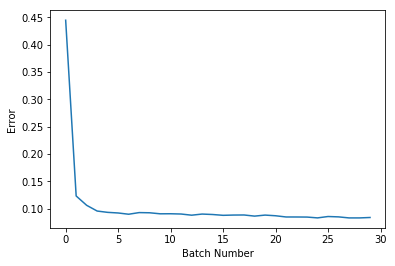

In [14]:
#Parameters
epochs = 5
batchsize = 100
weights = []
errors = []

for epoch in range(epochs):
    for start, end in zip( range(0, len(x_train), batchsize), range(batchsize, len(x_train), batchsize)):
        batch = x_train[start:end]
        cur_w = sess.run(update_w, feed_dict={ v0_state: batch, W: prev_w, v_bias: prev_v_bias, h_bias: prev_h_bias})
        cur_v_bias = sess.run(update_v_bias, feed_dict={v0_state: batch, W: prev_w, v_bias: prev_v_bias, h_bias: prev_h_bias})
        cur_h_bias = sess.run(update_h_bias, feed_dict={ v0_state: batch, W: prev_w, v_bias: prev_v_bias, h_bias: prev_h_bias})
        prev_w = cur_w
        prev_v_bias = cur_v_bias
        prev_h_bias = cur_h_bias
        if start % 10000 == 0:
            errors.append(sess.run(error, feed_dict={v0_state: x_train, W: cur_w, v_bias: cur_v_bias, h_bias: cur_h_bias}))
            weights.append(cur_w)
    print ('Epoch: %d' % epoch,'Reconstruction error: %f' % errors[-1])
plt.plot(errors)
plt.xlabel("Batch Number")
plt.ylabel("Error")
plt.show()

Final weights after training

In [15]:
final_weights = weights[-1].T
print(final_weights)

[[-1.0750643  -1.1133147  -1.1463399  ... -1.168404   -1.051862
  -1.1001923 ]
 [-0.81589943 -0.82392347 -0.80628216 ... -0.8733097  -0.8238196
  -0.80004734]
 [-0.6134586  -0.6213038  -0.67666566 ... -0.628407   -0.6987818
  -0.62659055]
 ...
 [-1.4696549  -1.3938642  -1.3058805  ... -1.3153322  -1.3852495
  -1.4579492 ]
 [-0.2602083  -0.2641153  -0.2353055  ... -0.252124   -0.25507587
  -0.23986055]
 [-1.0002064  -1.0071805  -0.99207574 ... -0.99445504 -1.1150358
  -1.0163962 ]]


Visualization

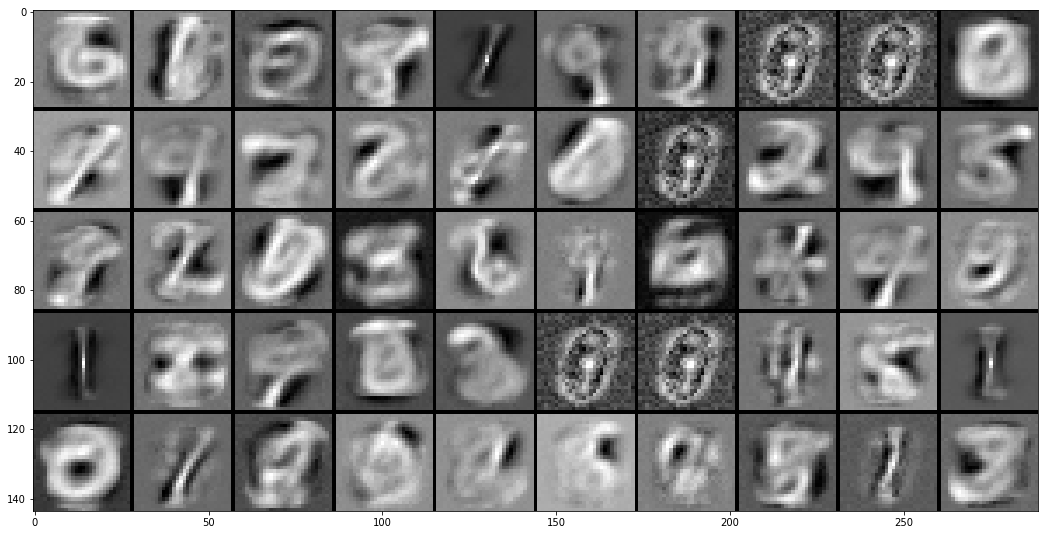

In [16]:
tile_raster_images(X=cur_w.T, img_shape=(28,28), tile_shape=(5,10), tile_spacing=(1,1))
image = Image.fromarray(tile_raster_images(X=cur_w.T, img_shape=(28,28), tile_shape=(5,10), tile_spacing=(1,1)))
plt.rcParams['figure.figsize'] = (18.0, 18.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')

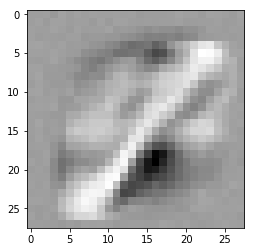

In [18]:
image = Image.fromarray(tile_raster_images(X=cur_w.T[10:11], img_shape=(28,28), tile_shape=(1,1), tile_spacing = (1,1)))
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(image)
imgplot.set_cmap('gray')

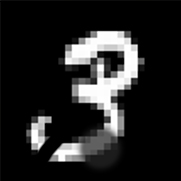

In [19]:
img = Image.open('destroyed.jpg')
img

Pass through the net

In [20]:
sample_case = np.array(img.convert('I').resize((28,28))).ravel().reshape((1,-1))/255.0

Reconstructing the input

In [21]:
hh0_p = tf.nn.sigmoid(tf.matmul(v0_state, W) + h_bias)
hh0_s = tf.round(hh0_p)
hh0_p_val, hh0_s_val = sess.run((hh0_p, hh0_s), feed_dict={v0_state: sample_case, W:prev_w, h_bias: prev_h_bias})
print("Probability nodes in hidden layer: ", hh0_p_val)
print("Activated noded in hidden layer: ", hh0_s_val)

# RECONSTRUCT
vv1_p = tf.nn.sigmoid(tf.matmul(hh0_s_val, tf.transpose(W)) + v_bias)
rec_prob = sess.run(vv1_p, feed_dict={hh0_s: hh0_s_val, W: prev_w, v_bias: prev_v_bias})


Probability nodes in hidden layer:  [[0.00000000e+00 6.20480230e-14 1.00000000e+00 1.61512321e-06
  4.25090907e-36 6.45517175e-26 1.42541085e-05 6.15517015e-09
  6.90680846e-09 9.99992728e-01 7.87261132e-28 5.37002713e-28
  9.60249220e-25 3.10882628e-01 0.00000000e+00 6.85636915e-05
  8.57501661e-08 1.46334976e-04 0.00000000e+00 4.17729597e-16
  1.37148196e-10 8.81849838e-33 9.99296546e-01 1.00000000e+00
  0.00000000e+00 1.17186217e-04 1.03974186e-12 8.68827181e-26
  1.18630937e-26 9.92832541e-01 3.29920369e-35 6.62892777e-03
  9.45834708e-17 4.20159056e-22 7.73308660e-25 6.58380150e-09
  7.47894546e-09 3.41086827e-15 9.02134873e-20 1.72539095e-27
  1.12576858e-10 1.77195627e-08 4.48758662e-01 3.26229781e-02
  1.11512818e-05 3.41192219e-15 5.97091450e-04 3.55123702e-05
  4.08930600e-06 1.00000000e+00]]
Activated noded in hidden layer:  [[0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1.
  0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0.

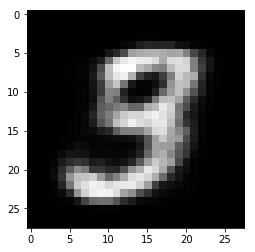

In [22]:
img = Image.fromarray(tile_raster_images(X=rec_prob, img_shape=(28, 28),tile_shape=(1, 1), tile_spacing=(1, 1)))
plt.rcParams['figure.figsize'] = (4.0, 4.0)
imgplot = plt.imshow(img)
imgplot.set_cmap('gray') 